In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uci-online-news-popularity-data-set/OnlineNewsPopularity.csv
/kaggle/input/uci-online-news-popularity-data-set/OnlineNewsPopularity.names


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## 資料前處理

### 1. 觀察資料
### 2. 清洗資料
### 3. 了解關係

In [3]:
# 載入資料初步檢查
df = pd.read_csv("/kaggle/input/uci-online-news-popularity-data-set/OnlineNewsPopularity.csv")
print(df.shape)
df.head()

(39644, 61)


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [4]:
# 檢查內容
df.info()
# 有39644筆資料，可查看有沒有缺失值及欄位的資料型態
df.describe()
# 資料集的所有統計數據

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords                   

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


In [5]:
# 處理欄位標題的空格
df.columns = df.columns.str.strip() 
# 移除無意義欄位(這邊刪除網址和更新時間)
df = df.drop(columns=['url', 'timedelta'])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


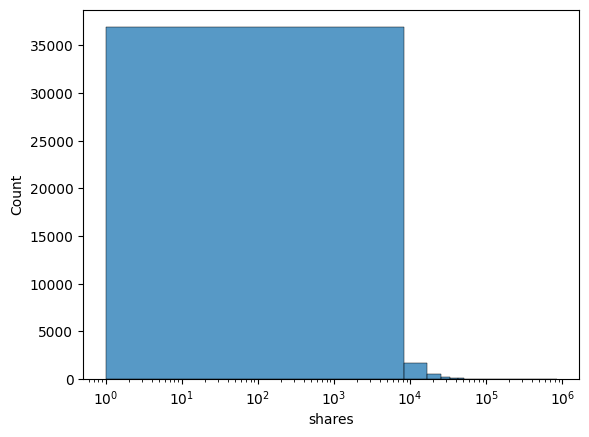

In [6]:
# 檢查欄位的分布（如偏態、極端值）
sns.histplot(df['shares'], bins=100)
plt.xscale('log') # 偏態嚴重

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


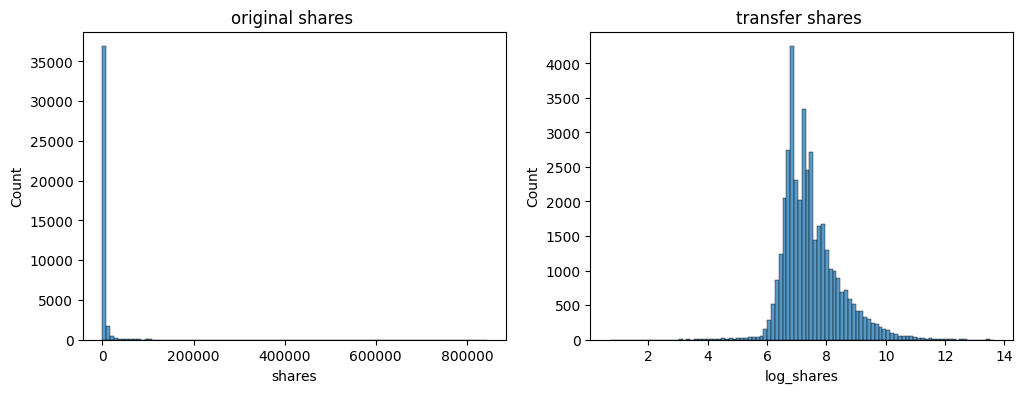

In [7]:
df['log_shares'] = np.log1p(df['shares']) # log1p->log(1+x)，避免x等於0的情況
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # 建立圖表區(1列，2欄，圖大小12寬X4高)
sns.histplot(df['shares'], bins=100, ax=axes[0])
axes[0].set_title('original shares ')
# axes[0].set_yscale('log')
sns.histplot(df['log_shares'], bins=100, ax=axes[1])
axes[1].set_title('transfer shares ')
plt.show()
# 偏態嚴重取log避免偏差過大

log_shares                    1.000000
shares                        0.510181
kw_avg_avg                    0.221822
LDA_03                        0.126037
is_weekend                    0.114391
kw_max_avg                    0.109343
kw_min_avg                    0.108850
num_hrefs                     0.105142
num_imgs                      0.091519
self_reference_avg_sharess    0.087238
Name: log_shares, dtype: float64
data_channel_is_bus             -0.030587
weekday_is_tuesday              -0.031095
avg_negative_polarity           -0.034323
weekday_is_wednesday            -0.036609
average_token_length            -0.045321
rate_negative_words             -0.048176
LDA_01                          -0.052992
data_channel_is_entertainment   -0.082531
data_channel_is_world           -0.151685
LDA_02                          -0.165076
Name: log_shares, dtype: float64


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


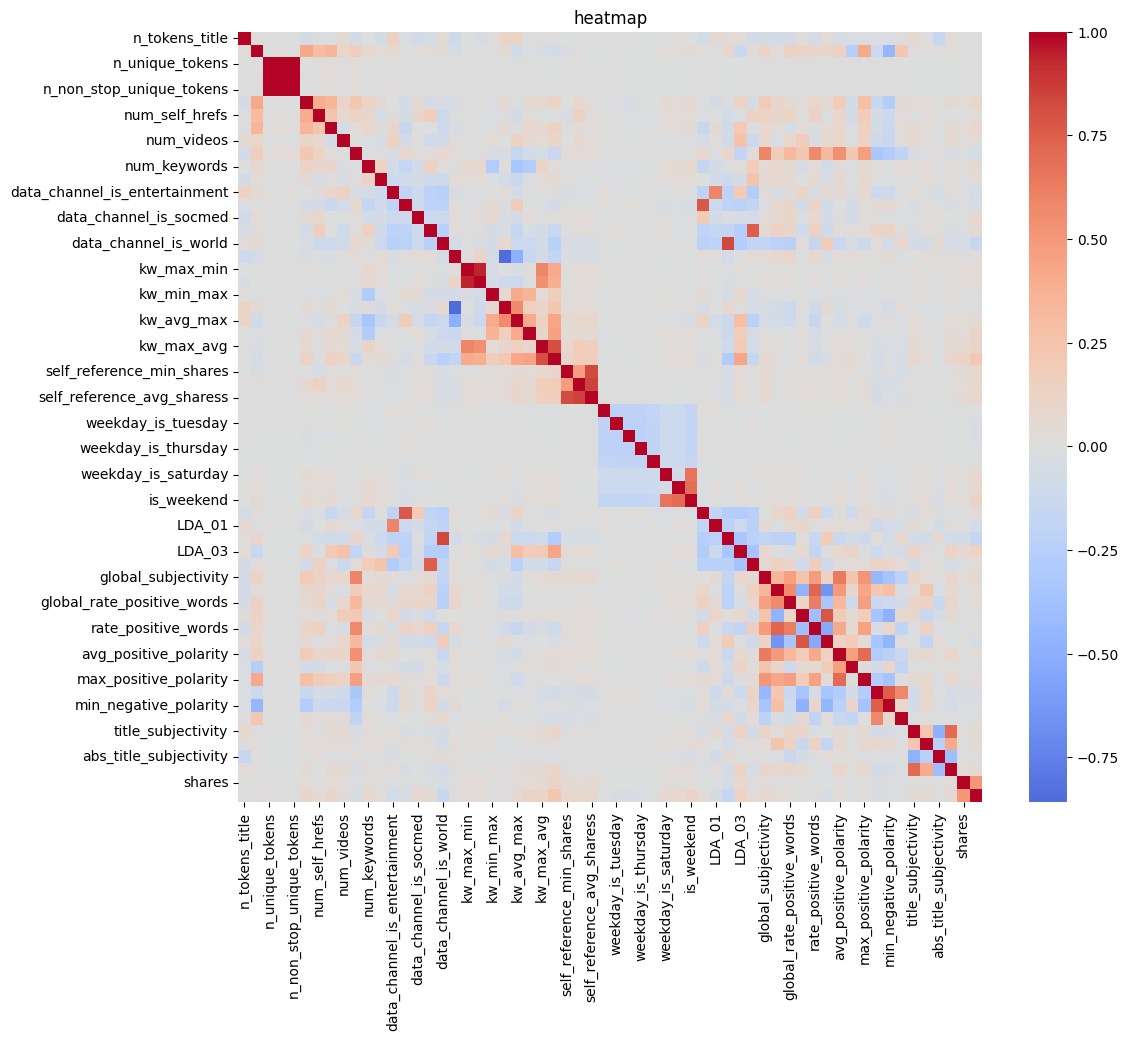

In [8]:
# 與 log_shares 的相關係數排序
correlations = df.corr(numeric_only=True)['log_shares'].sort_values(ascending=False)
print(correlations.head(10))  # 看正相關前10名
print(correlations.tail(10))  # 看負相關前10名

# 熱力圖觀察整體變數間的關係
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title('heatmap')
plt.show()


In [9]:
# 去除不需要的欄位（不使用原始shares）
df = df.drop(['shares'], axis=1)  # shares 已轉成 log_shares

# 避免 model 預測 shares 自己
target = 'log_shares'
X = df.drop(columns=[target])
y = df[target]

### SelectKBest：篩選前 K 個「最相關」的特徵
* 一種「特徵選擇」（Feature Selection）方法。
* 根據特定的統計評分方法（例如：f-score、mutual information），選出與目標變數最相關的前 K 個特徵。

In [30]:
from sklearn.feature_selection import SelectKBest, f_regression

# 根據線性回歸的 F 分數選出前 10 個特徵
selector = SelectKBest(score_func=f_regression, k=20)
X_new = selector.fit_transform(X, y)

# 查看被選中的特徵名稱
selected_features = selector.get_support(indices=True)
print(X.columns[selector.get_support()])

Index(['num_hrefs', 'num_imgs', 'num_keywords',
       'data_channel_is_entertainment', 'data_channel_is_socmed',
       'data_channel_is_world', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_saturday',
       'weekday_is_sunday', 'is_weekend', 'LDA_02', 'LDA_03',
       'global_subjectivity', 'abs_title_sentiment_polarity'],
      dtype='object')


## 模型建立
### 1. 決策樹
* 監督式學習模型
* 一連串「條件判斷」構成的樹狀結構
* 每個節點根據一個特徵進行「切分」，直到葉節點給出預測值（或類別）
* 注意：決策樹容易過擬合
* 類型：回歸或分類

In [11]:
# 決策樹
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# 資料訓練方法一：切分資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20%測試 80%訓練

tree = DecisionTreeRegressor(max_depth=5, random_state=42)  # 設定決策樹的最大深度，避免過度擬合（可調參）
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [12]:
# 檢查會不會 overfitting 或 underfitting
from sklearn.metrics import r2_score, mean_squared_error

# 訓練集與測試集的預測
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

# 評估 R^2 分數（評估預測的能力）
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# 評估 MSE（誤差值）
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

Train R²: 0.1199
Test R²: 0.1198
Train MSE: 0.7622
Test MSE: 0.7545


In [18]:
# 資料訓練方法二：使用 cross validation 交叉驗證
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# 評估
scores = cross_val_score(tree, X, y, cv=3, scoring='r2')
print("平均 R²：", np.mean(scores))

# 誤差
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
scores = cross_val_score(tree, X, y, cv=5, scoring=mse_scorer)
# 注意加負號轉正
print("平均 MSE：", -np.mean(scores))

各折 R² 分數： [0.06069634 0.07931036 0.08819596]
平均 R²： 0.0760675553217474
各折 MSE： [0.7986723  0.88767279 0.87128009 0.67727571 0.73604322]
平均 MSE： 0.7941888225349633


In [14]:
# 取得重要性分數
importances = tree.feature_importances_

# 建立 DataFrame 方便排序與觀察
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# 按照重要性排序，列出前幾項
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(10)

print(top_features)

                          feature  importance
25                     kw_avg_avg    0.486334
28     self_reference_avg_sharess    0.189219
24                     kw_max_avg    0.072364
12  data_channel_is_entertainment    0.051702
21                     kw_max_max    0.046362
36                     is_weekend    0.038176
15           data_channel_is_tech    0.027895
41                         LDA_04    0.019349
34            weekday_is_saturday    0.013559
20                     kw_min_max    0.012494


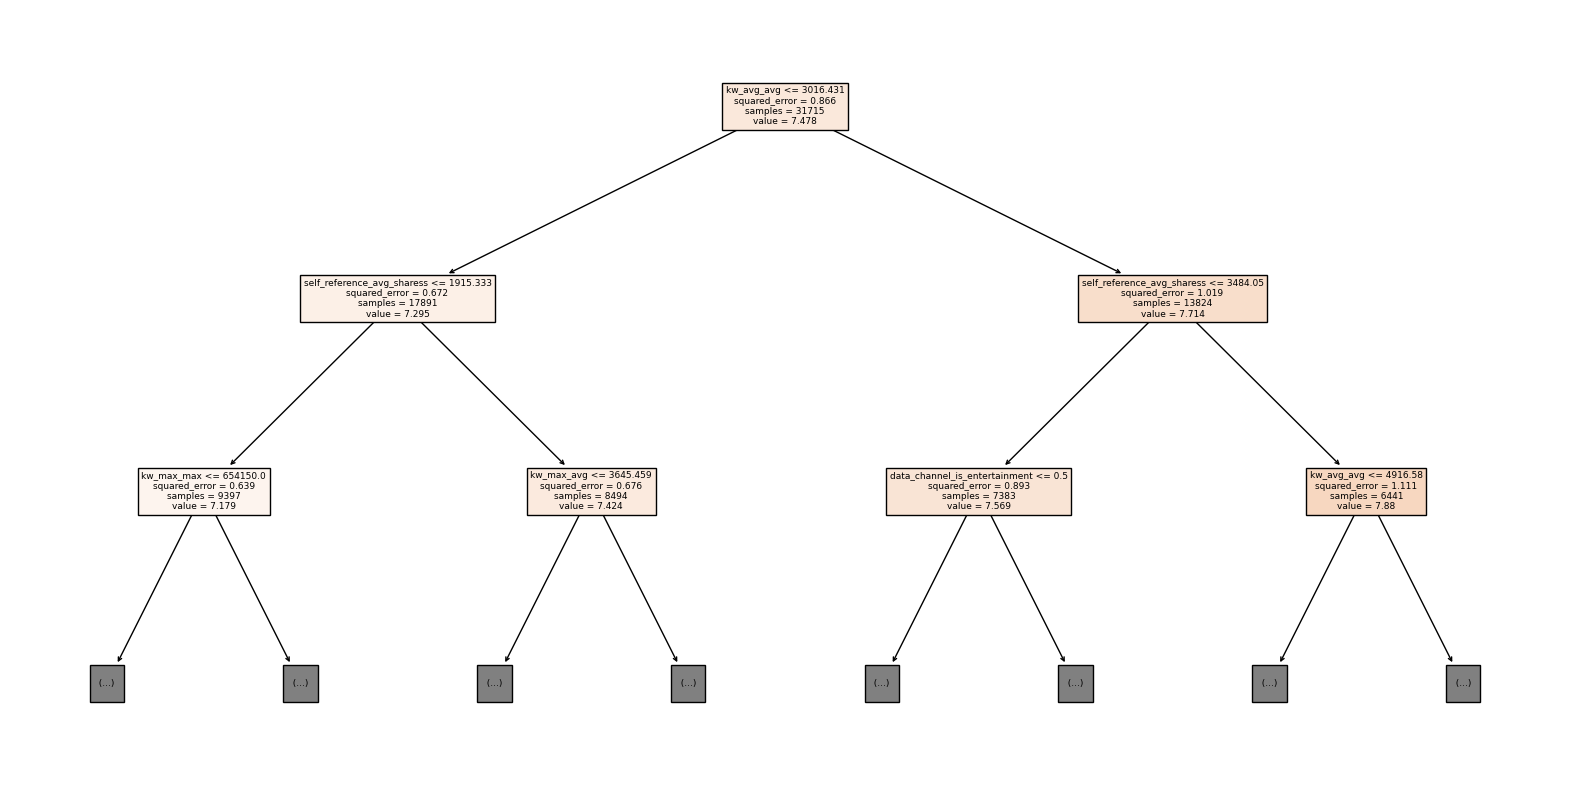

In [15]:
# 視覺了解前幾層是依據哪些特徵進行切割
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, filled=True, max_depth=2)
plt.show()

### 2. 隨機數森林
* 集成學習（Ensemble Learning）方法
* Bagging（Bootstrap Aggregating）：每棵樹訓練時隨機抽樣資料（有放回的抽樣）
* 隨機特徵選擇：每個節點只從隨機選出的一小部分特徵中選擇最佳分裂點

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 建立隨機森林模型
rf = RandomForestRegressor(random_state=42)

# 資料訓練：切分資料
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [32]:
# 資料訓練方法二：使用 cross validation 交叉驗證

# 評估
scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='r2')
print("各折 R² 分數：", scores)
print("Cross-Validation R² (mean):", np.mean(scores))

# 誤差
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
scores = cross_val_score(rf, X_train, y_train, cv=3, scoring=mse_scorer)
print("各折 MSE：", -scores)  # 注意加負號轉正
print("Cross-Validation MSE (mean)：", -np.mean(scores))

各折 R² 分數： [0.12688492 0.12795149 0.1158159 ]
Cross-Validation R² (mean): 0.12355077069046334
各折 MSE： [0.7752245  0.73397072 0.76791609]
Cross-Validation MSE (mean)： 0.7590371040162983


In [ ]:
# 用全部的訓練集重新訓練一次模型（準備測試用）
rf.fit(X_train, y_train)

# 在測試集上評估泛化效果
y_pred = rf.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
print("Test R²:", test_r2)
print("Test MSE:", test_mse)

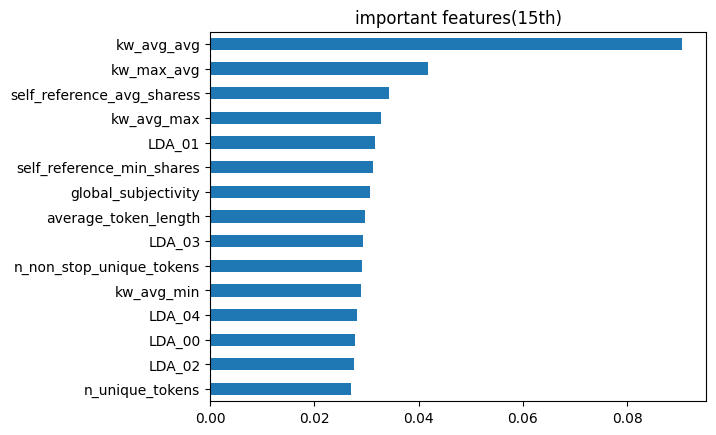

In [17]:
# 查看特徵重要性
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('important features(15th)')
plt.gca().invert_yaxis()
plt.show()